In [255]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from glob import glob
from const import ID2LABELS_SMG_SHORT as ID2LABELS
import ast
import plotly.express as px
from collections import Counter
import dash

In [256]:
os.environ['OMP_NUM_THREADS']='1'

In [354]:
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = 'resampled_64_multi_update_freq_8'
data_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\extracted_features'
dataset_path = osp.join(experiment_folder,run_name,'dataset', 'train.csv')
path_to_videos = r'D:\Project-mpg microgesture\smg\split_files_64'
# 

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'overfit_videomae_vit_base_patch16_224_kinetic_400_densepose_dual'
# data_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\overfit_videomae_vit_base_patch16_224_kinetic_400_densepose_dual\outputs\extracted_features'
# path_to_videos = r'D:\Project-mpg microgesture\smg\smg_split_files\train'
# dataset_path = osp.join(experiment_folder,run_name,'dataset','train.csv')




In [355]:
df_dataset = pd.read_csv(dataset_path)
df_dataset.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'filenames', 'folder_name', 'durations',
       'view', 'labels', 'metadata', 'labels_single'],
      dtype='object')

In [356]:
# load features
all_file_paths = glob(osp.join(data_folder, '*.npy'))
all_data_list = []
for p in all_file_paths:
    all_data_list.append(np.load(p))
concatenated_array = np.stack(all_data_list, axis=0)

In [357]:
concatenated_array.shape

(6192, 786)

In [358]:
file_ids = [float(osp.basename(f).split('.')[0].split('_ ')[1]) for f in all_file_paths]
file_ids = np.array(file_ids).reshape(-1,1)
concatenated_array = np.concatenate((concatenated_array,file_ids), axis=1)

In [359]:
# Reshape the concatenated array to shape (N/2, d, 2)
even_inds = np.expand_dims(concatenated_array[::2,: ], axis=2)
odd_inds = np.expand_dims(concatenated_array[1::2,: ], axis=2)
reshaped_array = np.concatenate((even_inds, odd_inds), axis=2).mean(axis=2, keepdims=False)

In [360]:
dim_data = 768 # 0 -> target_dim
target_dim = 17 # dim_data + 1 -> target_dim + 1 + target_dim
# target_dim = 1
index_dim = 1 + 1

In [361]:
ind_start = 0
ind_end = ind_start + dim_data
print(f'{ind_start=}, {ind_end-1=}')

X = reshaped_array[:, ind_start:ind_end]

ind_start = ind_end
ind_end = ind_start + target_dim
print(f'{ind_start=}, {ind_end-1=}')
y_multihot = even_inds[:,ind_start:ind_end].astype(int)

ind_start = ind_end
ind_end = ind_start + index_dim
print(f'{ind_start=}, {ind_end-1=}')
inds = even_inds[:,ind_start:ind_end].astype(int)
# y

ind_start=0, ind_end-1=767
ind_start=768, ind_end-1=784
ind_start=785, ind_end-1=786


In [362]:
print(f'Total shape: {reshaped_array.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y_multihot.shape}')
print(f'inds shape: {inds.shape}')
# assert X.shape[1] +  y.shape[1] + inds.shape[1] ==  reshaped_array.shape[1]
print(X.shape[1] +  y_multihot.shape[1] + inds.shape[1])

Total shape: (3096, 787)
X shape: (3096, 768)
y shape: (3096, 17, 1)
inds shape: (3096, 2, 1)
787


In [363]:
# keep only single labels
single_label_sample_inds = np.where(np.sum(y_multihot.squeeze(),axis=1) == 1)[0]
# X = X[single_label_sample_inds,:]
# y = np.argmax(y_multihot[single_label_sample_inds,:], axis=1).squeeze()
# inds = inds[single_label_sample_inds,:]
# 


In [364]:
X.shape

(3096, 768)

In [365]:
from sklearn.preprocessing import LabelEncoder
if y_multihot.shape[1] > 1:
    # Convert multi-hot to single label by concatenating the labels
    string_labels = [''.join(map(str, label)) for label in y_multihot]
    
    # Encode the string labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(string_labels)
else:
    y = y_multihot.squeeze()
y.shape

(3096,)

In [381]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

from umap import UMAP
reducer1 = UMAP(n_components=15,    n_neighbors=15)
reducer2 = UMAP(n_components=2, n_neighbors=5)


# reducer1 = PCA(n_components=15)
# reducer2 = UMAP(n_components=2)

In [382]:
X_reduced = reducer1.fit_transform(X, y=y)
embedding = reducer2.fit_transform(X_reduced, y=y)
# embedding = reducer2.fit_transform(X, y=y)

# X_reduced = reducer1.fit_transform(X)
# embedding = reducer2.fit_transform(X_reduced, y=y)

In [383]:
# # single_label_sample_inds
# X_reduced_single = X_reduced[single_label_sample_inds,:]
# embedding_signle = embedding[single_label_sample_inds,:]
# y_single = y[single_label_sample_inds]

In [384]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
# recuder = PCA(n_components=15)
# X_reduced = recuder.fit_transform(X)

In [385]:
from imblearn.under_sampling   import AllKNN, RepeatedEditedNearestNeighbours, EditedNearestNeighbours, NearMiss, TomekLinks,CondensedNearestNeighbour, NeighbourhoodCleaningRule, InstanceHardnessThreshold, RandomUnderSampler

from imblearn.combine import SMOTEENN

In [386]:
len(np.unique(y))

107

In [387]:
# resampler = TomekLinks(sampling_strategy='all')
# resampler = NearMiss()
# resampler = CondensedNearestNeighbour()
resampler = RandomUnderSampler()
# resampler = NeighbourhoodCleaningRule()
# resampler = InstanceHardnessThreshold()
# resampler =  AllKNN()
# resampler = RepeatedEditedNearestNeighbours()

# resampler = SMOTEENN()

# X_rus, y_rus = resampler.fit_resample(X, y)
X_rus, y_rus = resampler.fit_resample(X,y)
y_rus.shape

(107,)

In [388]:
sample_inds = resampler.sample_indices_

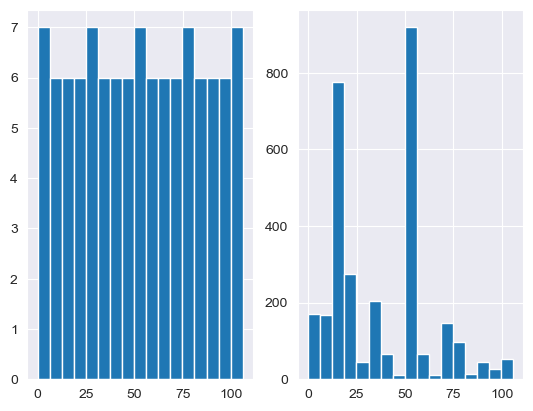

In [389]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(y_rus, bins=17)
axes[1].hist(y, bins=17)
plt.show()

In [390]:
y_rus.shape

(107,)

In [391]:
def get_counters(y_multihot, sample_inds, single_label_sample_inds):
    before = np.sum(y_multihot.squeeze(), axis=0)
    after = np.sum(y_multihot.squeeze()[sample_inds,:], axis=0)
    single = np.sum(y_multihot.squeeze()[single_label_sample_inds,:], axis=0)
    counts = {'before': before, 'after': after, 'single': single}
    df_counters = pd.DataFrame.from_dict(counts)
    df_counters.sort_index(inplace=True)
    df_counters = df_counters.reset_index()
    df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
    return df_counters
def scatter_plot(df_all):
# Create the scatter plot with Plotly Express
    fig = px.scatter(
        df_all, x='emb1', y='emb2',
        facet_col='sample', color='label',
        title='Scatter plot of emb1 vs emb2 faceted by sample and colored by label',
        hover_data=['file_names']
    )
    # Update traces to make markers larger and transparent
    # fig.update_traces(marker=dict(size=20, opacity=0.1))
    
    # Update layout for better spacing between facets
    fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), height=800, width=1600)
    
    
    # Show the plot
    fig.show()

# sum(ast.literal_eval(x.replace(' ',','))) == 1 or np.any(np.array(ast.literal_eval(x.replace(' ',',')))[[0,3]]==1))]

df_counters = get_counters(y_multihot, sample_inds, single_label_sample_inds)
df_counters

,index,before,after,single,label
0,0,51,6,33,Turtling neck
1,1,75,13,36,Rubbing face
2,2,263,17,138,Folding arms
3,3,15,6,6,Touching nose
4,4,1001,22,906,Moving legs
5,5,43,13,26,Scratching neck
6,6,148,16,82,Arms behind
7,7,418,19,230,Rubbing hands
8,8,1079,21,736,Arms akimbo
9,9,19,4,14,Crossing legs


In [393]:


# scatter_plot(df_all.loc[df_all['label_multi'].apply(lambda x: sum(x) == 1)])
# scatter_plot(df_all)

In [394]:
# np.where((s[:,4] == 1) & (np.sum(s, axis=1) > 1))
s.shape

(3096, 17)

In [395]:
# resample logic

MIN_SAMPLES = 500
MAX_SAMPLES = 500
s = y_multihot.squeeze()
  



# List of indices to subsample and upsample
subsample_inds = np.where(df_counters['single'] > MAX_SAMPLES)[0]
upsample_inds = np.where(df_counters['single'] < MIN_SAMPLES)[0]

# Condition 1: Rows where the sum of the row == 1 (one label)
condition1 = np.sum(s, axis=1) == 1

# Condition 2: Remove rows with a single label in subsample_inds unless they appear with labels in upsample_inds
single_label_in_subsample_inds = np.isin(np.argmax(s, axis=1), subsample_inds)
single_label_rows = (np.sum(s, axis=1) == 1)
remove_condition = single_label_rows & single_label_in_subsample_inds

# Check for rows where subsample_inds appear with upsample_inds
subsample_with_upsample = (np.sum(s[:, subsample_inds], axis=1) > 0) & (np.sum(s[:, upsample_inds], axis=1) > 0)

# Combine conditions: keep rows that meet condition1 but not the remove_condition, unless subsample_with_upsample is true
condition2 = ~remove_condition | subsample_with_upsample

# Condition 3: Add rows with more than one label from indices in upsample
upsample_condition = (np.sum(s[:, upsample_inds], axis=1) > 1)

# Combine conditions
combined_condition = (condition1 & condition2) | upsample_condition

# Get the indices of rows that match the combined condition
indices = np.where(combined_condition)[0]
SAMPLE_SIZE = 100
# indices_expanded = np.unique(np.concatenate([indices]))
# randomly select 50 samples from moving legs and arm akimso
single_moving_legs = (s[:, 4] == 1) & (np.sum(s, axis=1) == 1) 
inds_moving_legs = np.where(single_moving_legs)[0]
inds_to_sample = np.random.choice(inds_moving_legs, size=SAMPLE_SIZE, replace=False)
inds_to_add = inds_to_sample.tolist()

single_moving_legs = (s[:, 8] == 1) & (np.sum(s, axis=1) == 1) 
inds_moving_legs = np.where(single_moving_legs)[0]
inds_to_sample = np.random.choice(inds_moving_legs, size=SAMPLE_SIZE, replace=False)
inds_to_add += inds_to_sample.tolist()

len(inds_to_add)

200

In [396]:
indices_supplemented = np.array(indices.tolist()+inds_to_add)

In [397]:

# single_label_sample_inds_adjusted = list(set(np.where(np.sum(s,axis=1) == 1)[0].tolist() + np.where(s[:,inflated_labels].sum(axis=2).squeeze()>0)[0].tolist()))
# single_label_sample_inds_adjusted = np.where((s[:,4] == 1) & (np.sum(s, axis=1) > 1))[0].tolist() + np.where((s[:,8] == 1) & (np.sum(s, axis=1) > 1))[0].tolist() + 

df_counters = get_counters(y_multihot, indices_supplemented, single_label_sample_inds)
df_counters

,index,before,after,single,label
0,0,51,41,33,Turtling neck
1,1,75,71,36,Rubbing face
2,2,263,183,138,Folding arms
3,3,15,9,6,Touching nose
4,4,1001,103,906,Moving legs
5,5,43,40,26,Scratching neck
6,6,148,115,82,Arms behind
7,7,418,300,230,Rubbing hands
8,8,1079,104,736,Arms akimbo
9,9,19,18,14,Crossing legs


In [398]:
min_samples = df_counters['before'].min()


In [399]:
y_multihot.shape

(3096, 17, 1)

In [400]:
is_multi = True
def multihot_to_labels(multi_hot_labels, is_multi=is_multi):
    if is_multi:
        label_inds = np.where(multi_hot_labels == 1)[0]
    else:
        label_inds = [multi_hot_labels]
    ret = [ID2LABELS[x+1] for x in label_inds]
    ret.sort()
    return '+'.join(ret)

# test
# multi_hot_labels = df.loc[df['label'].apply(lambda x: sum(x) > 1)].iloc[2]['label']
# multihot_to_labels(multi_hot_labels)

In [421]:
np.max(indices_supplemented)

3095

In [414]:
df = pd.DataFrame(zip(embedding[:,0], embedding[:, 1], y_multihot.squeeze()), columns=['emb1', 'emb2', 'label'])
df['label_multi'] = df['label'] 
df['inds'] = inds[:,0]
df['file_paths'] = df_dataset['filenames'].apply(lambda x: osp.join(path_to_videos, x))
df['file_names'] = df_dataset['filenames']
df['label'] = df['label'].apply(lambda x: multihot_to_labels(x))
df['sample'] = 'all'
# df_sub = df.iloc[sample_inds,:].copy()
df_sub = df.iloc[indices_supplemented,:].copy()

df_sub['sample'] = 'resample'
df_all = pd.concat([df, df_sub], axis=0)
df_all = df_all.sort_values(by='label')
# sns.relplot(
#     data=df_all, x="emb1", y="emb2",
#     col="sample", hue="label",
#     kind="scatter"
# )

In [415]:
# df_all.to_csv(r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\embedded_data.csv')

# df_all.to_csv(r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\embedded_data_expanded.csv')

In [416]:

scatter_plot(df_all.loc[df_all['label_multi'].apply(lambda x: sum(x) == 1)])
scatter_plot(df_all)

In [417]:
len(df_all)

4362

In [406]:

# df_all = pd.read_csv(r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\embedded_data.csv')
# df_all['label_multi'] = df_all['label_multi'].apply(lambda x: ast.literal_eval(x.replace(' ',',')))
# df_all_single = df_all.loc[df_all['label_multi'].apply(lambda x: sum(x) == 1)]


In [407]:
# len(df_all_single)

In [408]:
run_name

'resampled_64_multi_update_freq_8'

In [424]:
# resample train data
import shutil
train_data_path = osp.join(experiment_folder, run_name,'dataset - full','train_full.csv')
df_train_orig = pd.read_csv(train_data_path)
# 
# back up
# Create the new file name by replacing '.csv' with '_full.csv'
# new_file_path = train_data_path.replace('.csv', '_full.csv')
# 
# Copy the original file to the new file path
# shutil.copy(train_data_path, new_file_path)


# train_data_path = osp.join(experiment_folder, run_name,'dataset','train.csv').replace('.csv', '_full.csv')
# df_train_orig = pd.read_csv(train_data_path)

In [425]:
df_train_orig

,Unnamed: 0,filenames,folder_name,durations,view,labels,metadata
0,0,0001_001_00831-00895_14.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. ...,"{'sample_id': '0001_001_00831-00895_14', 'star..."
1,1,0001_002_01697-01761_11.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"{'sample_id': '0001_002_01697-01761_11', 'star..."
2,2,0001_004_06317-06381_7.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0001_004_06317-06381_7', 'start..."
3,3,0001_006_06501-06565_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0001_006_06501-06565_8', 'start..."
4,4,0001_008_06611-06675_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0001_008_06611-06675_8', 'start..."
...,...,...,...,...,...,...,...
3091,3091,0032_011_14345-14409_5.mp4,NaN,64,center,[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0032_011_14345-14409_5', 'start..."
3092,3092,0032_012_14357-14421_5-7.mp4,NaN,64,center,[0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0032_012_14357-14421_5-7', 'sta..."
3093,3093,0032_013_16889-16953_7.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0032_013_16889-16953_7', 'start..."
3094,3094,0032_014_16953-17017_11.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"{'sample_id': '0032_014_16953-17017_11', 'star..."


In [426]:
# df_train_new = df_train_orig.loc[df_train_orig['labels'].apply(lambda x: sum(ast.literal_eval(x.replace(' ',','))) == 1)].copy()
# df_train_new['labels_single'] = df_train_new['labels'].apply(lambda x: np.argmax(ast.literal_eval(x.replace(' ',','))))
# df_train_new['labels_single']

df_train_new = df_train_orig.iloc[indices_supplemented,:].copy()
df_train_new
# labels = df_train_new['labels'].apply(lambda x: np.argmax(ast.literal_eval(x)))

,Unnamed: 0,filenames,folder_name,durations,view,labels,metadata
0,0,0001_001_00831-00895_14.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. ...,"{'sample_id': '0001_001_00831-00895_14', 'star..."
1,1,0001_002_01697-01761_11.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"{'sample_id': '0001_002_01697-01761_11', 'star..."
2,2,0001_004_06317-06381_7.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0001_004_06317-06381_7', 'start..."
11,11,0001_021_08424-08488_1.mp4,NaN,64,center,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0001_021_08424-08488_1', 'start..."
16,16,0001_031_14618-14682_11.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"{'sample_id': '0001_031_14618-14682_11', 'star..."
...,...,...,...,...,...,...,...
1733,1733,0019_081_23446-23510_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0019_081_23446-23510_8', 'start..."
987,987,0013_167_18893-18957_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0013_167_18893-18957_8', 'start..."
1214,1214,0015_188_19274-19338_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0015_188_19274-19338_8', 'start..."
681,681,0010_168_22006-22070_8.mp4,NaN,64,center,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,"{'sample_id': '0010_168_22006-22070_8', 'start..."


In [427]:
print(len(df_train_new))
# print(len(df_all))
# print(len(df_all_single))

1266


In [428]:
df_train_new['metadata'].iloc[0]

"{'sample_id': '0001_001_00831-00895_14', 'start_frame': 164, 'end_frame': 228, 'label': [14], 'view': 'center', 'filenames': '0001_001_00831-00895_14.mp4', 'durations': 64}"

In [471]:
save_train_data_path = osp.join(experiment_folder, run_name,'resampled','dataset','train.csv')
df_train_new.to_csv(save_train_data_path)


In [472]:
# labels = df_train_new['labels_single']
labels = df_train_new['labels'].apply(lambda x: np.array(ast.literal_eval(x.replace(' ',',')))).values
labels = np.stack(labels)

In [473]:
# labels.unique()

In [474]:
# plt.hist(labels)
labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [475]:
def get_class_weights(df,feature_names, alpha=10, beta=2):
    class_weights = {}
    positive_weights = {}
    negative_weights = {}
    support = {}
    # N = len(df)
    n_features = len(feature_names)

    N = np.sum(df[feature_names].to_numpy())
    for label in feature_names:
        if label in df.columns:
            positive_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 1))+1)*beta)
            negative_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 0))+1)*beta)
            support[label] = sum(df[label] == 1)
        else:
            positive_weights[label] = 0
            negative_weights[label] = 0
            support[label] = 0


            
    # class_weights['positive_weights'] = pd.DataFrame.from_dict(positive_weights)
    # class_weights['negative_weights'] = pd.DataFrame.from_dict(negative_weights)
    class_weights = pd.DataFrame(zip(positive_weights.keys(),positive_weights.values(), negative_weights.values(), support.values()),columns=['class','positive_weights','negative_weights','support'])        
    class_weights['method'] = 'inv'
    return class_weights

In [470]:
# # recalculate weights, use sklearn
# from sklearn.utils.class_weight import compute_class_weight
# 
# # classes = labels.unique()
# classes = ID2LABELS.keys()
# class_weights_vals = compute_class_weight(class_weight="balanced", classes=ID2LABELS.keys(), y=labels)
# # compute_class_weight()
# class_weights = pd.DataFrame(zip(classes, class_weights_vals), columns=['class', 'positive_weights'])
# class_weights.sort_values(by='class', inplace=True)
# class_weights
feature_names = [x-1 for x in ID2LABELS.keys()]
df_multihot = pd.DataFrame(labels.tolist())
class_weights = get_class_weights(df_multihot,feature_names, alpha=2, beta=1)

In [55]:
# before = Counter([a[0] for a in y])
# after = Counter([a for a in y_rus])
# new = Counter(labels)
# counts = {'before': before, 'after': after, 'new':new, 'weights': {a:b for a,b in zip(classes, class_weights_vals)}}
# df_counters = pd.DataFrame.from_dict(counts)
# df_counters.sort_index(inplace=True)
# df_counters = df_counters.reset_index()
# df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
# df_counters

In [233]:
save_folder = osp.join(experiment_folder, run_name,'resampled','dataset')
os.makedirs(save_folder)
class_weights.to_csv(osp.join(save_folder, 'weights.csv'))
import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)